# About the notebook
- title: "BIOS824 Case Studies HW02"
- author: "Kuei-Yueh Ko"


In [1]:
### library: basic
import numpy as np

### library: keras
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

### library: reading images
from keras import applications
from keras.preprocessing import image

### library: plotting
import matplotlib.pyplot as plt

### helper function
head = lambda x, n = 6: x[:n]
tail = lambda x, n = 6: x[-n:]

Using TensorFlow backend.


**set directory**

In [2]:
### Mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

%cd "/content/gdrive/My Drive/Colab Notebooks/Duke_BIOS824_CaseStudies"
!pwd
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/Duke_BIOS824_CaseStudies
/content/gdrive/My Drive/Colab Notebooks/Duke_BIOS824_CaseStudies
data					    mod01_lec02_cnn_mnist.ipynb
figures					    mod01_nn_overtrain_early_stop.ipynb
mod01_cnn_tutorial01_mnist_basic.ipynb	    mod01_try_google_colab.ipynb
mod01_cnn_tutorial02_keras_vis.ipynb	    README.md
mod01_hw01_image_apply_linear_filter.ipynb  scripts
mod01_hw02_cnn_mnist_overtrain.ipynb


-----

# Load MNIST data and preprocess
The MNIST data can be loaded from Keras datasets.

**Load MNIST data and preprocess images**

In [3]:
### input image dimensions
img_rows, img_cols = 28, 28

### the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')
x_train /= 255
x_test  /= 255

### Add Channel Dimension
### (N, 28, 28) -> (N, 28, 28, 1)
### (N, 28, 28) -> (N, 1, 28, 28)
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
### observe data dimension
print("X_train:", x_train.shape)
print("y_train:", y_train.shape)
print("X_test: ", x_test.shape)
print("y_test: ", y_test.shape)

11493376/11490434 [==============================] - 1s 0us/step
X_train: (60000, 28, 28, 1)
y_train: (60000,)
X_test:  (10000, 28, 28, 1)
y_test:  (10000,)


In [4]:
K.image_data_format()

'channels_last'

In [5]:
x_train[0].shape

(28, 28, 1)

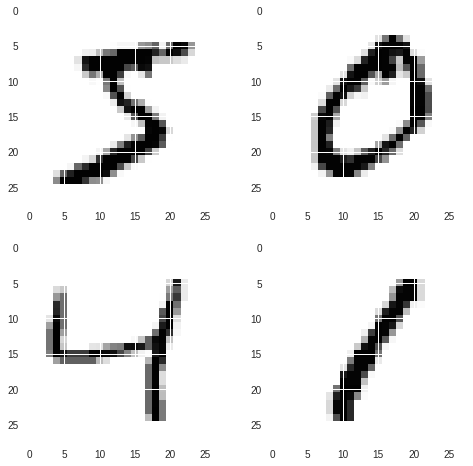

In [6]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize = (8, 8))

axes[0, 0].imshow(x_train[0][:, :, 0])

axes[0, 1].imshow(x_train[1][:, :, 0])

axes[1, 0].imshow(x_train[2][:, :, 0])

axes[1, 1].imshow(x_train[3][:, :, 0])
pass

**Preprocess class labels**

In [7]:
# number of classes
num_classes = 10

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("y_train:", y_train.shape)
print("y_test: ", y_test.shape)

y_train: (60000, 10)
y_test:  (10000, 10)


In [8]:
print(y_train[:3])
print("=============================")
print(np.where(y_train[:3] == 1.0)[1])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
[5 0 4]


In [9]:
### observe data dimension
print("X_train:", x_train.shape)
print("y_train:", y_train.shape)
print("X_test: ", x_test.shape)
print("y_test: ", y_test.shape)

X_train: (60000, 28, 28, 1)
y_train: (60000, 10)
X_test:  (10000, 28, 28, 1)
y_test:  (10000, 10)


# Building model and train

In [10]:
### Convolutional Neural Network
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

### Multilayer Perceptron (fully connected network)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

### Softmax operation
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

### model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [11]:
### define number of epoch
epochs     = 15
batch_size = 64

### fit the model
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test))

### Store the results
history01 = history
model01   = model

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 19s 324us/step - loss: 0.2206 - acc: 0.9326 - val_loss: 0.0510 - val_acc: 0.9838
Epoch 2/15
60000/60000 [==============================] - 15s 249us/step - loss: 0.0796 - acc: 0.9767 - val_loss: 0.0404 - val_acc: 0.9872
Epoch 3/15
60000/60000 [==============================] - 15s 247us/step - loss: 0.0624 - acc: 0.9807 - val_loss: 0.0400 - val_acc: 0.9864
Epoch 4/15
60000/60000 [==============================] - 15s 247us/step - loss: 0.0528 - acc: 0.9842 - val_loss: 0.0382 - val_acc: 0.9874
Epoch 5/15
60000/60000 [==============================] - 15s 246us/step - loss: 0.0462 - acc: 0.9863 - val_loss: 0.0301 - val_acc: 0.9903
Epoch 6/15
60000/60000 [==============================] - 15s 247us/step - loss: 0.0432 - acc: 0.9874 - val_loss: 0.0303 - val_acc: 0.9896
Epoch 7/15
60000/60000 [==============================] - 15s 242us/step - loss: 0.0384 - acc: 0.9882 - val_loss: 0.

In [12]:
### get the end score
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:',     score[0])
print('Test accuracy:', score[1])

Test loss: 0.027191661432714183
Test accuracy: 0.9918


**Visualizing loss and accuracy**

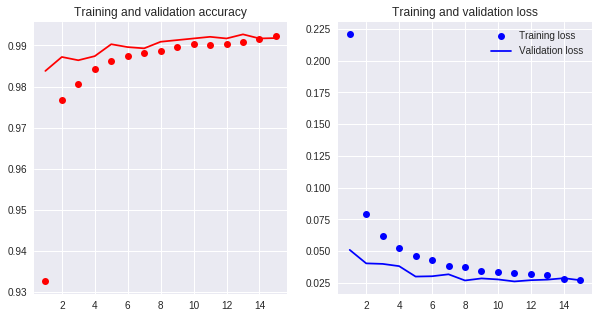

In [13]:
### init
history = history01

### get accuracy and loss along the iterations
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(1, len(acc) + 1)

### plot accuracy
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (10, 5))
ax = axes[0]
ax.plot(epochs, acc,     'bo', c = "red", label='Training acc')
ax.plot(epochs, val_acc, 'b',  c = "red", label='Validation acc')
ax.set_title('Training and validation accuracy')

ax = axes[1]
ax.plot(epochs, loss,     'bo', c = "blue", label='Training loss')
ax.plot(epochs, val_loss, 'b',  c = "blue", label='Validation loss')
ax.set_title('Training and validation loss')
ax.legend()

plt.show()

# Try to overtrain
First try: reduce the number of training set

**Re-build the model**

In [14]:
### Convolutional Neural Network
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

### Multilayer Perceptron (fully connected network)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

### Softmax operation
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

### model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

**Reduce the training dataset**

In [15]:
### observe data dimension
print("Original")
print("X_train:", x_train.shape)
print("y_train:", y_train.shape)
print("X_test: ", x_test.shape)
print("y_test: ", y_test.shape)

### reducing training data
x_train_red = x_train[:1000]
y_train_red = y_train[:1000]

### After reducing data
print("Reduce")
print("X_train:", x_train_red.shape)
print("y_train:", y_train_red.shape)
print("X_test: ", x_test.shape)
print("y_test: ", y_test.shape)

Original
X_train: (60000, 28, 28, 1)
y_train: (60000, 10)
X_test:  (10000, 28, 28, 1)
y_test:  (10000, 10)
Reduce
X_train: (1000, 28, 28, 1)
y_train: (1000, 10)
X_test:  (10000, 28, 28, 1)
y_test:  (10000, 10)


**Train the model**

In [16]:
### define number of epoch
epochs     = 100
batch_size = 64

### fit the model
history = model.fit(
    x_train_red, y_train_red,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test))

### Store the results
history02 = history
model02   = model

Train on 1000 samples, validate on 10000 samples
Epoch 1/100
1000/1000 [==============================] - 1s 1ms/step - loss: 1.7835 - acc: 0.3730 - val_loss: 0.9085 - val_acc: 0.7231
Epoch 2/100
1000/1000 [==============================] - 1s 835us/step - loss: 0.8789 - acc: 0.7230 - val_loss: 0.5739 - val_acc: 0.8106
Epoch 3/100
1000/1000 [==============================] - 1s 823us/step - loss: 0.5695 - acc: 0.8250 - val_loss: 0.4377 - val_acc: 0.8567
Epoch 4/100
1000/1000 [==============================] - 1s 812us/step - loss: 0.4187 - acc: 0.8750 - val_loss: 0.3883 - val_acc: 0.8678
Epoch 5/100
1000/1000 [==============================] - 1s 811us/step - loss: 0.3218 - acc: 0.9030 - val_loss: 0.3214 - val_acc: 0.8990
Epoch 6/100
1000/1000 [==============================] - 1s 813us/step - loss: 0.2728 - acc: 0.9180 - val_loss: 0.2899 - val_acc: 0.9090
Epoch 7/100
1000/1000 [==============================] - 1s 827us/step - loss: 0.2022 - acc: 0.9420 - val_loss: 0.2439 - val_acc: 0

**Visualizing loss and accuracy**

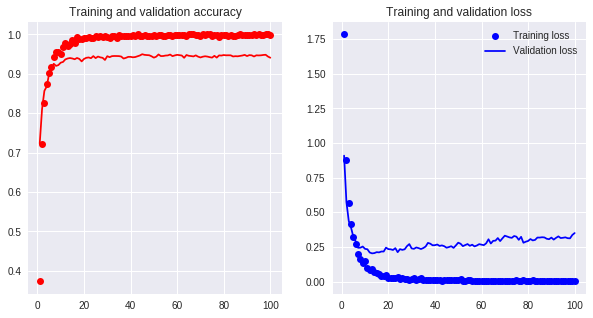

In [17]:
### init
history = history02

### get accuracy and loss along the iterations
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(1, len(acc) + 1)

### plot accuracy
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (10, 5))
ax = axes[0]
ax.plot(epochs, acc,     'bo', c = "red", label='Training acc')
ax.plot(epochs, val_acc, 'b',  c = "red", label='Validation acc')
ax.set_title('Training and validation accuracy')

ax = axes[1]
ax.plot(epochs, loss,     'bo', c = "blue", label='Training loss')
ax.plot(epochs, val_loss, 'b',  c = "blue", label='Validation loss')
ax.set_title('Training and validation loss')
ax.legend()

plt.show()

# Overtrain by modifying the model

**Modify the model: remove dropout**

In [18]:
### Convolutional Neural Network
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

### Multilayer Perceptron (fully connected network)
model.add(Flatten())
model.add(Dense(128, activation='relu'))

### Softmax operation
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

### model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
_________________________________________________________________


In [19]:
### define number of epoch
epochs     = 100
batch_size = 64

### fit the model
history = model.fit(
    x_train_red, y_train_red,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test))

### Store the results
history03 = history
model03   = model

Train on 1000 samples, validate on 10000 samples
Epoch 1/100
1000/1000 [==============================] - 1s 1ms/step - loss: 1.6158 - acc: 0.4800 - val_loss: 1.1354 - val_acc: 0.6685
Epoch 2/100
1000/1000 [==============================] - 1s 744us/step - loss: 0.7073 - acc: 0.7790 - val_loss: 0.5433 - val_acc: 0.8303
Epoch 3/100
1000/1000 [==============================] - 1s 750us/step - loss: 0.3768 - acc: 0.8900 - val_loss: 0.3908 - val_acc: 0.8793
Epoch 4/100
1000/1000 [==============================] - 1s 750us/step - loss: 0.2622 - acc: 0.9210 - val_loss: 0.3604 - val_acc: 0.8899
Epoch 5/100
1000/1000 [==============================] - 1s 742us/step - loss: 0.1736 - acc: 0.9440 - val_loss: 0.3556 - val_acc: 0.8822
Epoch 6/100
1000/1000 [==============================] - 1s 744us/step - loss: 0.1406 - acc: 0.9600 - val_loss: 0.2867 - val_acc: 0.9137
Epoch 7/100
1000/1000 [==============================] - 1s 745us/step - loss: 0.0711 - acc: 0.9800 - val_loss: 0.2684 - val_acc: 0

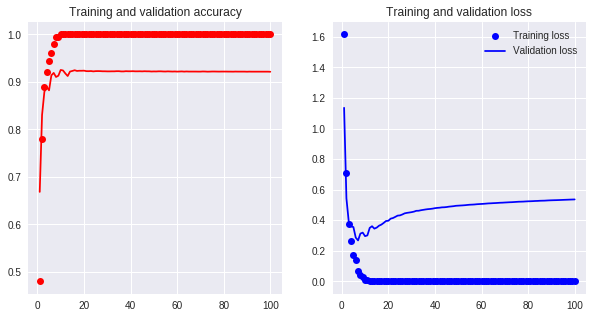

In [20]:
### init
history = history03

### get accuracy and loss along the iterations
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(1, len(acc) + 1)

### plot accuracy
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (10, 5))
ax = axes[0]
ax.plot(epochs, acc,     'bo', c = "red", label='Training acc')
ax.plot(epochs, val_acc, 'b',  c = "red", label='Validation acc')
ax.set_title('Training and validation accuracy')

ax = axes[1]
ax.plot(epochs, loss,     'bo', c = "blue", label='Training loss')
ax.plot(epochs, val_loss, 'b',  c = "blue", label='Validation loss')
ax.set_title('Training and validation loss')
ax.legend()

plt.show()

# Keep increasing the model

In [21]:
### Convolutional Neural Network
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))

### add one more conv2d layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

### Multilayer Perceptron (fully connected network)
model.add(Flatten())
model.add(Dense(128, activation='relu'))

### add one more dense layer
model.add(Dense(128, activation='relu'))

### Softmax operation
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

### model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 22, 22, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               991360    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
__________

In [22]:
### define number of epoch
epochs     = 100
batch_size = 64

### fit the model
history = model.fit(
    x_train_red, y_train_red,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test))

### Store the results
history04 = history
model04   = model

Train on 1000 samples, validate on 10000 samples
Epoch 1/100
1000/1000 [==============================] - 2s 2ms/step - loss: 1.8979 - acc: 0.3540 - val_loss: 1.4755 - val_acc: 0.5576
Epoch 2/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.8640 - acc: 0.7430 - val_loss: 0.5868 - val_acc: 0.8475
Epoch 3/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.4852 - acc: 0.8520 - val_loss: 0.9098 - val_acc: 0.7412
Epoch 4/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.3096 - acc: 0.9120 - val_loss: 0.2782 - val_acc: 0.9114
Epoch 5/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1754 - acc: 0.9490 - val_loss: 0.4604 - val_acc: 0.8700
Epoch 6/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1087 - acc: 0.9630 - val_loss: 0.2918 - val_acc: 0.9098
Epoch 7/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0599 - acc: 0.9810 - val_loss: 0.3365 - val_acc: 0.9036
Epoch 

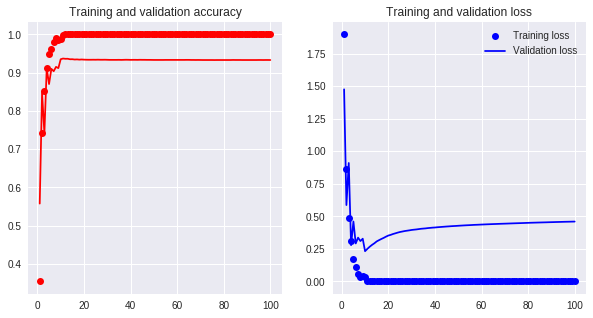

In [23]:
### init
history = history04

### get accuracy and loss along the iterations
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(1, len(acc) + 1)

### plot accuracy
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (10, 5))
ax = axes[0]
ax.plot(epochs, acc,     'bo', c = "red", label='Training acc')
ax.plot(epochs, val_acc, 'b',  c = "red", label='Validation acc')
ax.set_title('Training and validation accuracy')

ax = axes[1]
ax.plot(epochs, loss,     'bo', c = "blue", label='Training loss')
ax.plot(epochs, val_loss, 'b',  c = "blue", label='Validation loss')
ax.set_title('Training and validation loss')
ax.legend()

plt.show()